# Модель Prophet (Мисюк Вячеслав ИСП-21)

<h3> Подключаем библиотеки

In [537]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

<h3> Очищаем данные

In [538]:
def clean_data(train_path: str, test_path: str, additional_dir: str):

    # Загрузка данных
    train = pd.read_excel(train_path, parse_dates=['dt'], engine='openpyxl')
    test_main = pd.read_excel(test_path, parse_dates=['dt'], engine='openpyxl')
    test_main['dt'] = pd.to_datetime(test_main['dt'])
    additional_files = list(Path(additional_dir).glob('*.xlsx'))
    
    # Загрузка и объединение всех данных
    all_dfs = [train]
    for file in additional_files:
        train_df = pd.read_excel(file, engine='openpyxl')
        train_df['dt'] = pd.to_datetime(train_df['dt'])
        all_dfs.append(train_df)
    
    # Объединение данных в один список
    combined = pd.concat(all_dfs, ignore_index=True)
    
    # Определяем начало недели (понедельник)
    combined['week_start'] = combined['dt'] - pd.to_timedelta(combined['dt'].dt.dayofweek, unit='D')
    
    # Агрегация по медиане для всех числовых колонок
    numeric_cols = combined.select_dtypes(include=['number']).columns.tolist()
    weekly_df = combined.groupby('week_start')[numeric_cols].median().reset_index()
    
    # Переименовываем колонку week_start в dt
    train_df = weekly_df.rename(columns={'week_start': 'dt'})

    train_df = train_df.replace('', np.nan)  # Заменяем пустые строки на NaN
    train_df = train_df.replace(0, np.nan)  # Заменяем 0 на NaN
    train_df = train_df.replace('0', np.nan) # Заменяем строковое "0" на NaN

    # Заполняем пропуски, который образовались из-за разрыва месячных данных на недели
    for col in train_df.columns:
        first_valid_index = train_df[col].first_valid_index()
        if first_valid_index is not None:
            non_nan_indices = train_df[col].dropna().index
            for index in non_nan_indices:
                fill_indices = range(index + 1, min(index + 1 + 3, len(train_df)))
                for i in fill_indices:
                    if pd.isna(train_df.loc[i, col]):
                        train_df.loc[i, col] = train_df.loc[index, col]
    
    threshold = 0.70 # 70% пропусков допустимо, больше - удаляем колонку
    for col in train_df.columns:
        if train_df[col].isnull().sum() / len(train_df) > threshold:
            train_df.drop(col, axis=1, inplace=True)  # Удаляем слишком пустой столбец в цикле

    # Заполняем пропуски методом соседних значений
    train_df = train_df.ffill().bfill()  # Применяем ffill, а затем bfill

    # Выбор признаков с помощью ANOVA F-value
    selector = SelectKBest(score_func=f_regression, k=18)  # Оставим топ-18 признаков
    X_selected = selector.fit_transform(train_df.drop(['dt', 'price'], axis=1), train_df['price'])

    # Получение названий отобранных колонок
    selected_cols = train_df.drop(['dt', 'price'], axis=1).columns[selector.get_support()]
    print(f'Кол-во отобранные признаков: {len(selected_cols.tolist())}')

    # Обновление датафрейма
    train_df = train_df[['dt', 'price'] + selected_cols.tolist()]

    # Возвращаем готовый датасет
    return train_df, test_main

<h3> Проверяем стационарность данных

In [539]:
def check_stationary(train_df):
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['price'])
    plt.title('Динамика цены')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.grid(True)
    plt.show()

    result = adfuller(train_df['price'])
    print('До диффиционирования:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    train_df['price_diff'] = train_df['price'].diff().dropna()
    train_df = train_df.ffill().bfill()  # Применяем ffill, а затем bfill

    print()
    print('После диффиционирования:')
    result = adfuller(train_df['price_diff'])
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    plt.figure(figsize=(12, 6))
    plt.plot(train_df['price_diff'])
    plt.title('Стационарный ряд (1-я разность)')
    plt.xlabel('Дата')
    plt.ylabel('Изменение цены')
    plt.grid(True)
    plt.show()
    return train_df

<h3> Разделяем датафрейм на обучающий и тестируемый

In [540]:
def split_train_df(train_df):
    test_df = train_df[train_df['dt'] > pd.to_datetime('2022-08-29')]
    test_df = test_df[test_df['dt'] <= pd.to_datetime('2023-03-13')]
    train_df = train_df[train_df['dt'] <= pd.to_datetime('2022-08-29')]

    del test_df['price']
    return train_df, test_df

<h3> Запускаем def-ы

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\slava\AppData\Local\Temp\ipykernel_16960\245645606.py:1: SyntaxWarning: invalid escape sequence '\V'
  train_df, test_main = clean_data(train_path='train.xlsx', test_path = 'test.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data') # Соединили и очистили данные


Кол-во отобранные признаков: 18


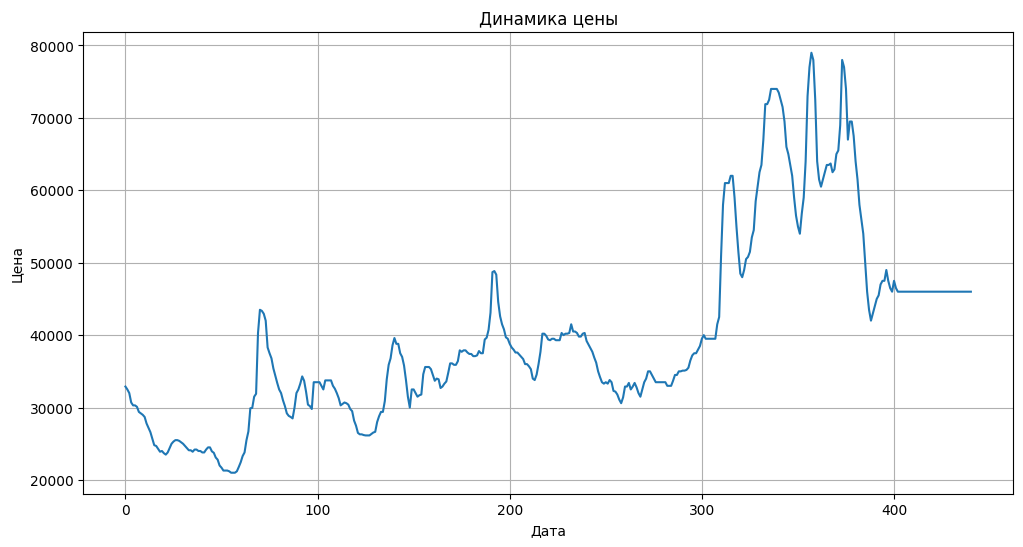

До диффиционирования:
ADF Statistic: -2.0138432880085175
p-value: 0.2805364794997386

После диффиционирования:
ADF Statistic: -8.137993443968572
p-value: 1.0465430139506535e-12


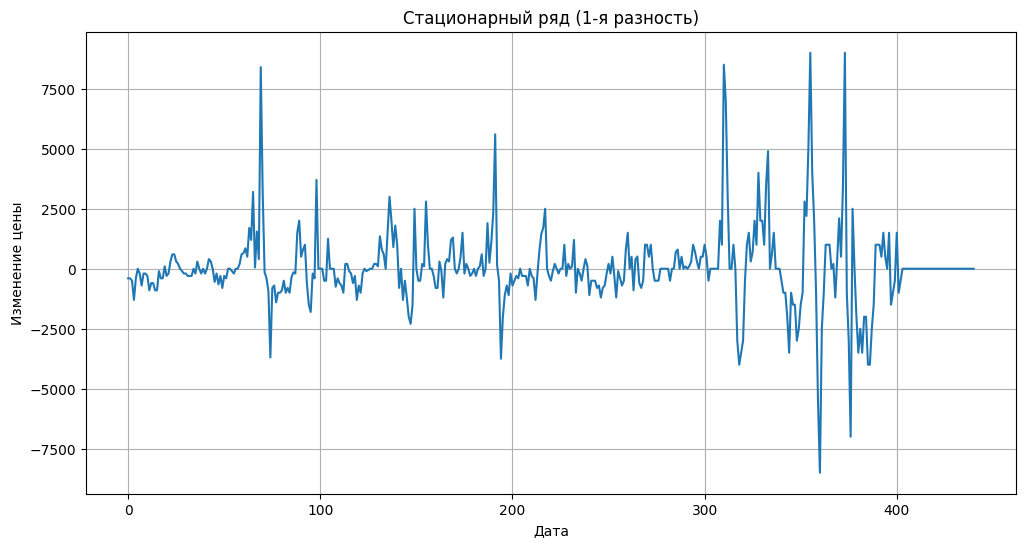

In [541]:
train_df, test_main = clean_data(train_path='train.xlsx', test_path = 'test.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data') # Соединили и очистили данные
train_df = check_stationary(train_df)
train_df, test_df = split_train_df(train_df) # Разделяем датафрейм на обучающий и тестируемый
train_df.to_excel('merged_data.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет

<h3> Проверка готовых колонок

In [542]:
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
boolean_columns = train_df.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в train: {len(numeric_columns)}")
print(f"Категориальные колонки в train: {len(categorical_columns)}")
print(f"Булевые колонки в train: {len(boolean_columns)}")


Числовые колонки в train: 20
Категориальные колонки в train: 0
Булевые колонки в train: 0


<h3> Проверка пустых колонок

<Axes: >

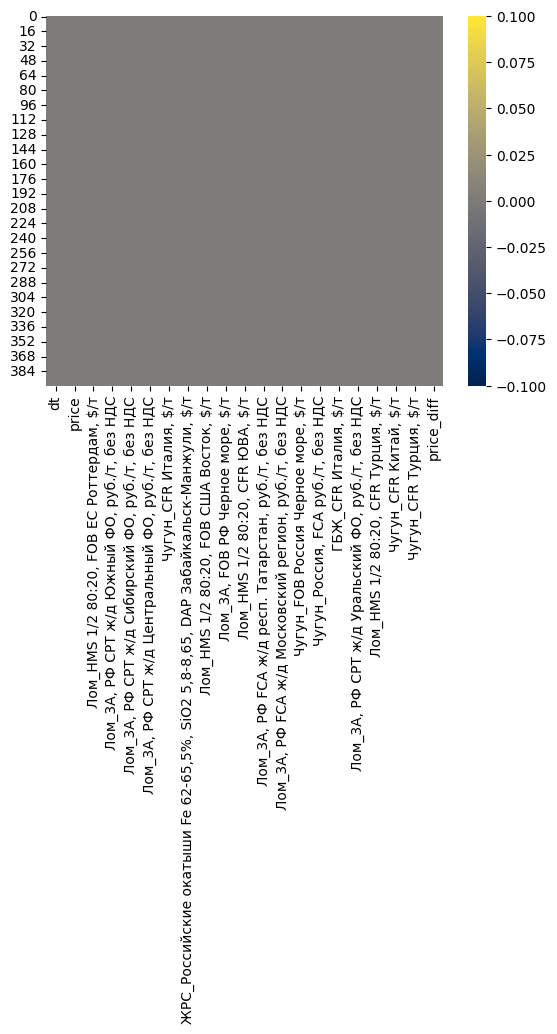

In [543]:
sns.heatmap(train_df.isnull(), cmap='cividis')

<h3> Обучение модели

In [544]:
# 1. Подготовка обучающих данных
train_df = train_df.rename(columns={'dt': 'ds', 'price': 'y'})
train_df['ds'] = pd.to_datetime(train_df['ds'])

# 2. Инициализация модели с настройками
model = Prophet(
    weekly_seasonality=True,
    changepoint_prior_scale=0.03,  # Снижаем чувствительность к выбросам
    growth='linear',  # Ограничиваем рост
    seasonality_mode='multiplicative',  # Для нелинейной сезонности
)

# Добавляем регрессоры явно (убедитесь, что они есть в test_df)
required_regressors = [col for col in train_df.columns if col not in ['ds', 'y']]
for regressor in required_regressors:
    model.add_regressor(regressor)

# 3. Подготовка тестовых данных
test_df = test_df.rename(columns={'dt': 'ds'})
test_df['ds'] = pd.to_datetime(test_df['ds'])

# 4. Обучение модели
model.fit(train_df)

23:17:55 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing


<h3> Прогнозирование цены

            ds  predicted_price
400 2022-09-05          47500.0
401 2022-09-12          42000.0
402 2022-09-19          41000.0
403 2022-09-26          42500.0
404 2022-10-03          45200.0
405 2022-10-10          44500.0
406 2022-10-17          43500.0
407 2022-10-24          41200.0
408 2022-10-31          41000.0
409 2022-11-07          41700.0
410 2022-11-14          42100.0
411 2022-11-21          38600.0
412 2022-11-28          38500.0
413 2022-12-05          39000.0
414 2022-12-12          39600.0
415 2022-12-19          39600.0
416 2022-12-26          40000.0
417 2023-01-02          41100.0
418 2023-01-09          43600.0
419 2023-01-16          43700.0
420 2023-01-23          44100.0
421 2023-01-30          43600.0
422 2023-02-06          45000.0
423 2023-02-13          44300.0
424 2023-02-20          45300.0
425 2023-02-27          46100.0
426 2023-03-06          48600.0
427 2023-03-13          50600.0
MAE: 1789.29
R2-score: 0.59


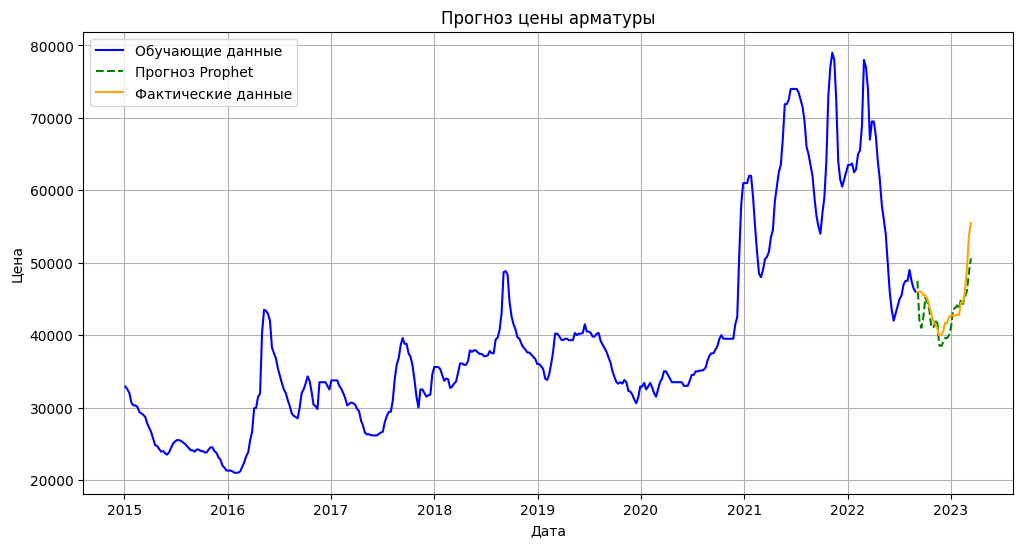

In [545]:
# 5. Прогнозирование
forecast = model.predict(test_df)

# 6. Добавляем прогнозы в test_df
test_df['predicted_price'] = forecast['yhat'].values
test_df['predicted_price'] = round(test_df['predicted_price'], -2)
print(test_df[['ds', 'predicted_price']])

# Вычисление метрик
y_true = test_main['price']
test_df['predicted_price'] = pd.to_numeric(test_df['predicted_price'])
y_pred = test_df['predicted_price']

print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"R2-score: {r2_score(y_true, y_pred):.2f}")


# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Обучающие данные', color='blue')
plt.plot(test_df['ds'], test_df['predicted_price'], label='Прогноз Prophet', color='green', linestyle='--')
plt.plot(test_main['dt'], test_main['price'], label='Фактические данные', color='orange')

plt.title('Прогноз цены арматуры')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

test_df.to_excel('predicted_price.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет